In [1]:
%load_ext autoreload
%autoreload 2
device = "cuda:7"

# import the usual resources
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from card_data_load import FacialKeypointsDataset
from card_data_load import Rescale, RandomCrop, CenterCrop, Normalize, ToTensor

from models import Net
n_points = 4
net = Net(n_points)
net = net.to(device)

In [3]:

train_transform = transforms.Compose([Rescale(256),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

test_transform = transforms.Compose([Rescale(256),
                                     CenterCrop(224),
                                     Normalize(),
                                     ToTensor()])

In [4]:
# create the transformed dataset
train_dataset = FacialKeypointsDataset(csv_file='carddata/train_landmark.csv',
                                             root_dir='carddata/train',
                                             transform=train_transform)

test_dataset = FacialKeypointsDataset(csv_file='carddata/test_landmark.csv',
                                             root_dir='carddata/test',
                                             transform=test_transform)

print('Number of images: ', len(train_dataset))
print()
# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = train_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
    
for i in range(4):
    sample = test_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  5940

0 torch.Size([1, 224, 224]) torch.Size([4, 2])
1 torch.Size([1, 224, 224]) torch.Size([4, 2])
2 torch.Size([1, 224, 224]) torch.Size([4, 2])
3 torch.Size([1, 224, 224]) torch.Size([4, 2])
0 torch.Size([1, 224, 224]) torch.Size([4, 2])
1 torch.Size([1, 224, 224]) torch.Size([4, 2])
2 torch.Size([1, 224, 224]) torch.Size([4, 2])
3 torch.Size([1, 224, 224]) torch.Size([4, 2])


In [5]:
# load training data in batches
batch_size = 8

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size, 
                          num_workers=0)

In [6]:
import torch.optim as optim

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(params = net.parameters(), lr = 0.001)
scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, verbose=True)

In [7]:
def train_net(n_epochs):
    best_model = net
    prev_loss = 9999999999
    batch_loss = 0
    # prepare the net for training
    net.train()
    result = pd.DataFrame()

    for epoch in tqdm(range(n_epochs)):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        current_lr = optimizer.param_groups[0]['lr']
        print("learning rate:",current_lr)

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(tqdm(train_loader)):
            images = data['image']
            key_pts = data['keypoints']

            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss/batch_i+1
        
        test_loss =  test(epoch)
        scheduler.step(test_loss)
        
        result = result.append([[epoch,train_loss,test_loss,current_lr]])
        result.to_csv("card_result_eff0.csv",index=False)
        print("epoch:", epoch, "train_loss:",train_loss, "test_loss:",test_loss)
        if test_loss < prev_loss:
            print("saving")
            best_model = net
            prev_loss = test_loss
            torch.save(best_model, f"card_saved_models/best_model_pad_eff0{epoch}_{round(train_loss,4)}_{round(test_loss,4)}")
        else:
            print("model is not improve")
    print('Finished Training')
    return result

def test(epoch):
    net.eval()
    test_loss = 0
    with torch.no_grad():
         for batch_i, data in enumerate(tqdm(test_loader)):
        
        # get sample data: images and ground truth keypoints
            images = data['image']
            key_pts = data['keypoints']
            
            key_pts = key_pts.view(key_pts.size(0), -1)

            key_pts = key_pts.type(torch.FloatTensor).to(device)
            images = images.type(torch.FloatTensor).to(device)

            # forward pass to get net output
            output_pts = net(images)
            loss = criterion(output_pts, key_pts)
            test_loss += loss.item()
    test_loss = test_loss/batch_i+1
    return test_loss

In [10]:
# train your network
n_epochs = 100 # start small, and increase when you've decided on your model structure and hyperparams

result1 = train_net(n_epochs)

In [ ]:
## prediction

In [11]:
def net_sample_output(net=net):
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image'].to(device)
        key_pts = sample['keypoints'].to(device)

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor).to(device)

        # forward pass to get net output
        output_pts = net(images)
        print(output_pts.shape)
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 4, -1)
        print(output_pts.shape)
        # break after first image is tested
#         if i == 0:
        return images, output_pts, key_pts

In [12]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

In [13]:
def load_best_model(path):
    model = torch.load(path)
    return model

In [16]:
best_model = load_best_model("card_saved_models/best_model_pad_36_1.0011_1.0015")
test_images, test_outputs, gt_pts = net_sample_output(best_model)

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([8, 8])
torch.Size([8, 4, 2])
torch.Size([8, 1, 224, 224])
torch.Size([8, 4, 2])
torch.Size([8, 4, 2])


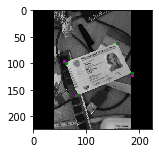

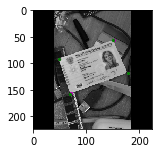

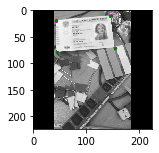

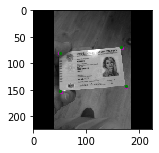

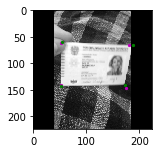

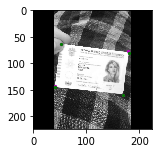

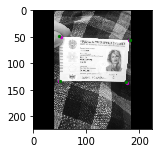

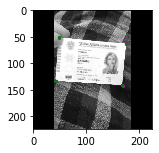

In [17]:
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(8):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, 8, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.cpu().numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts.cpu())
            
#         plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)